In [50]:
#Установка периода прогнозирования
from datetime import datetime
start_time = datetime.now()
print('\033[1m' + 'УСТАНОВКА ПЕРИОДА ПРОГНОЗИРОВАНИЯ:' + '\033[0m')
cd1     = 'Начальный месяц для месячного прогнозирования и его дневной детализации (в формате "ГГГГ-ММ"): '
cd2     = 'Конечный месяц для месячного прогнозирования (в формате "ГГГГ-ММ"): '
daily   = input(cd1)
monthly = input(cd2) 
inp     = './salesdaily.csv' #путь к файлу с историческим фактом

print(f'{cd1}{daily}')
print(f'{cd2}{monthly}')

УСТАНОВКА ПЕРИОДА ПРОГНОЗИРОВАНИЯ:
Начальный месяц для месячного прогнозирования и его дневной детализации (в формате "ГГГГ-ММ"): 2019-08
Конечный месяц для месячного прогнозирования (в формате "ГГГГ-ММ"): 2020-02


In [51]:
#Подключение библиотек:
from sklearn.metrics import mean_squared_error as mse, mean_absolute_percentage_error as mape, \
                            mean_absolute_error as mae
from statsmodels.tsa.api import ExponentialSmoothing, ETSModel, seasonal_decompose
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from scipy.optimize import minimize
from keras.layers import Dropout
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

In [52]:
#Задание временных рамок
dynam = pd.read_csv(inp).dropna(how='all')
dynam['datum'] = pd.to_datetime(dynam['datum'])
dynam = dynam.sort_values(by='datum') 
year_diff = 1

monthly = pd.to_datetime(monthly)
start =  pd.to_datetime(daily)
end = pd.to_datetime(start)
while end.month - start.month == 0:
    end += pd.DateOffset(days=1)
end -= pd.DateOffset(days=1)

ДИНАМИКА ПРОДАЖ РАЗНЫХ КАТЕГОРИЙ ЛЕКАРСТВ:


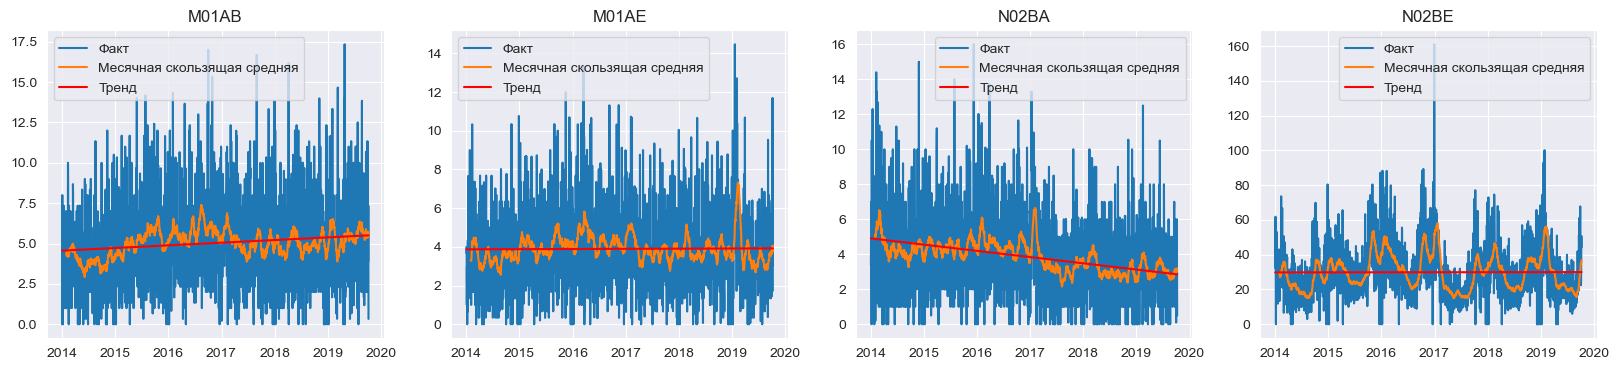

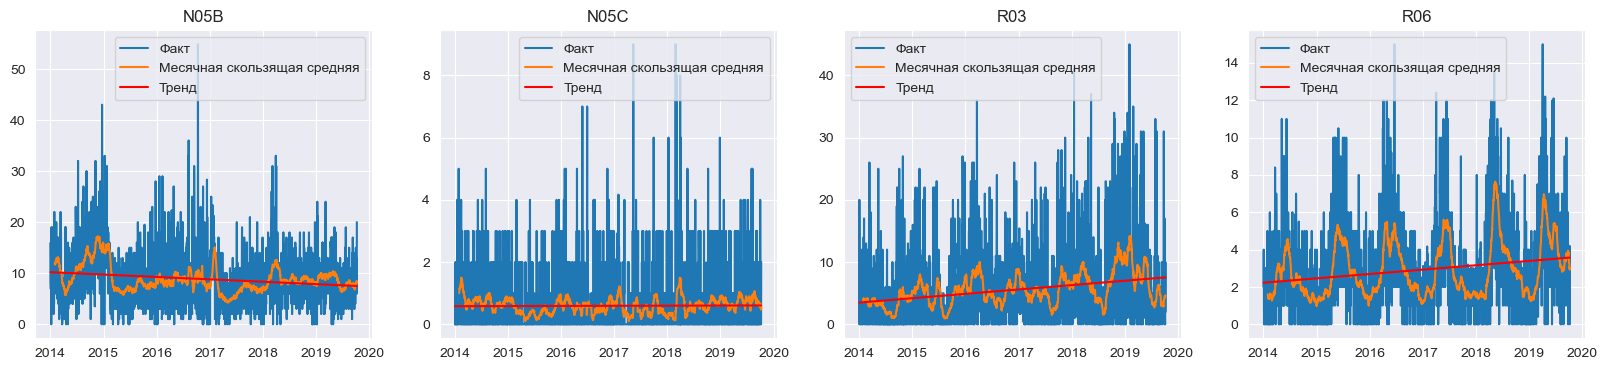

In [53]:
#Построение графиков динамики пролдаж по разным категориям
warnings.filterwarnings('ignore')
print('\033[1m' + 'ДИНАМИКА ПРОДАЖ РАЗНЫХ КАТЕГОРИЙ ЛЕКАРСТВ:' + '\033[0m')
col = dynam.columns.tolist()
col = [x for x in col if x not in ('datum', 'Year', 'Month', 'Hour', 'Weekday Name')] #Отбор только столбцов-категорий

for _, view in enumerate(col):
    if (_)%4+2 == 2:
        plt.figure(figsize=(20, 4))
    plt.subplot(1, 4, (_)%4+1)
    plt.plot(dynam['datum'], dynam[view], label = 'Факт')
    plt.plot(dynam['datum'], dynam[view].rolling(30).mean(), label = 'Месячная скользящая средняя')
    plt.title(view)
    z = np.polyfit(range(dynam['datum'].shape[0]), dynam[view], 1)
    p = np.poly1d(z)
    plt.plot(dynam['datum'], p(range(dynam['datum'].shape[0])), color = 'red', label = 'Тренд')
    plt.legend()
    if (_)%4+2 == 0: 
        plt.show()

**Как можно заметить: все паттерны фактов очень разные, что говорит о том, что, скорее всего, будут подходить разные методы прогнозирования для разных категорий товаров. Есть как восходящие тренды, так и затухающие, а также и практически полное отсутствие направленного движения ряда данных вовсе. Тем не менее, у всех динамик фактов есть сезонность: как аддитивная, так и мультипликативная, поэтому стоит рассматривать только те методы прогнозирования, которые способны учитывать сезонные колебания.**

ДЕКОМПОЗИЦИЯ ВРЕМЕННЫХ РЯДОВ РАЗНЫХ КАТЕГОРИЙ ЛЕКАРСТВ:


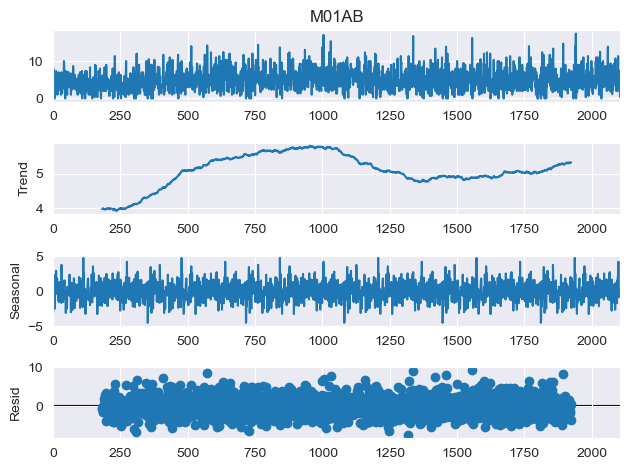

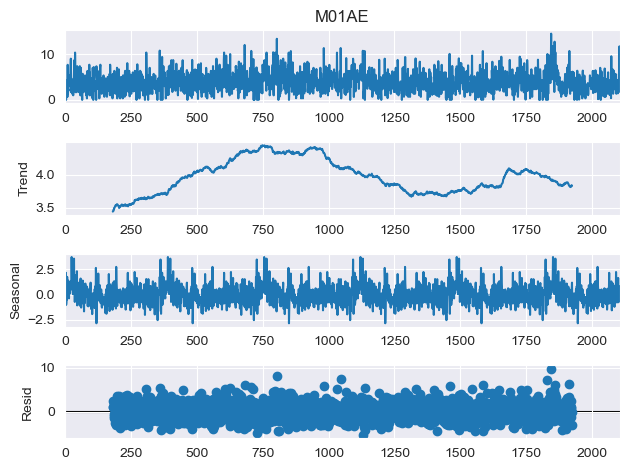

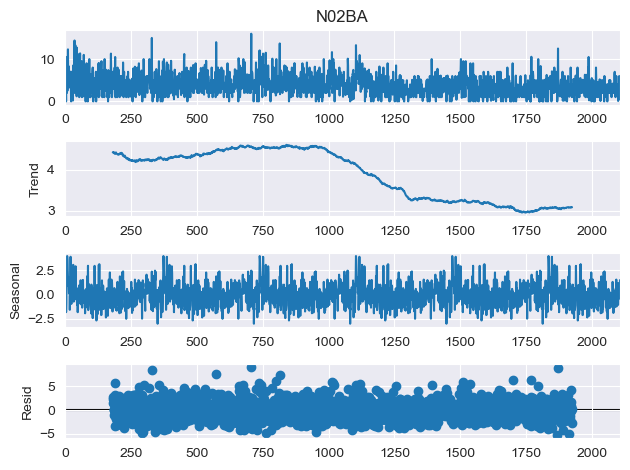

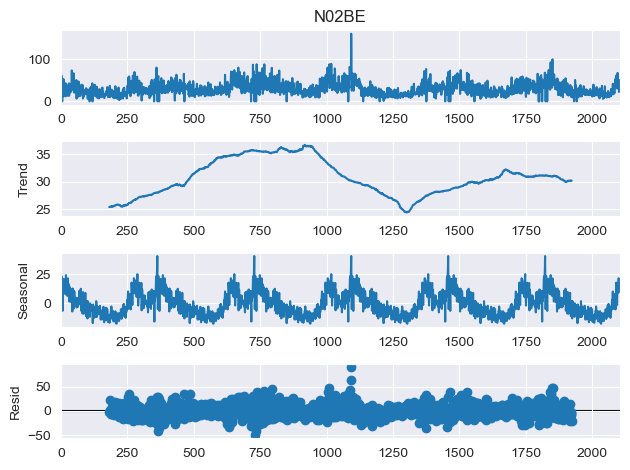

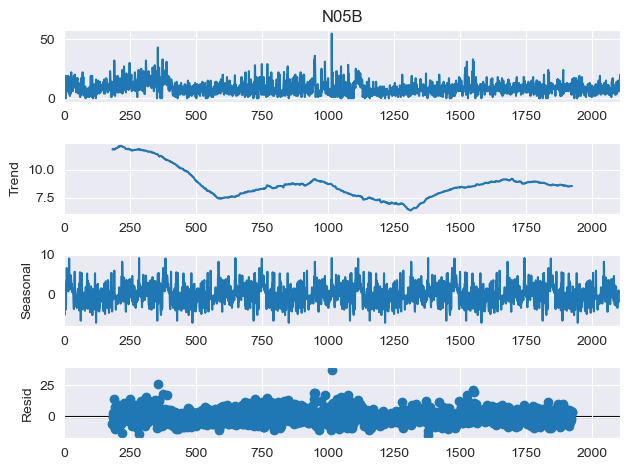

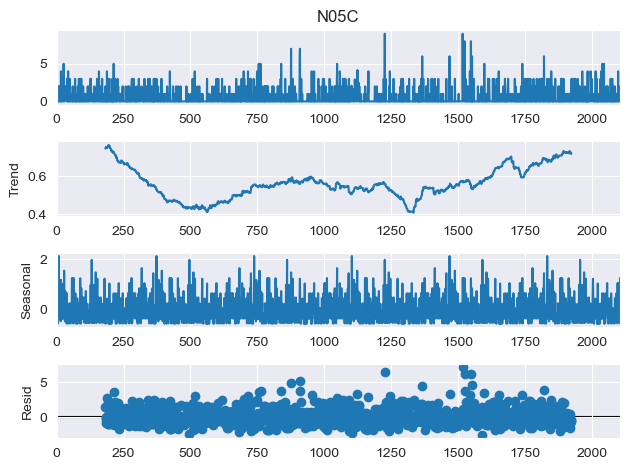

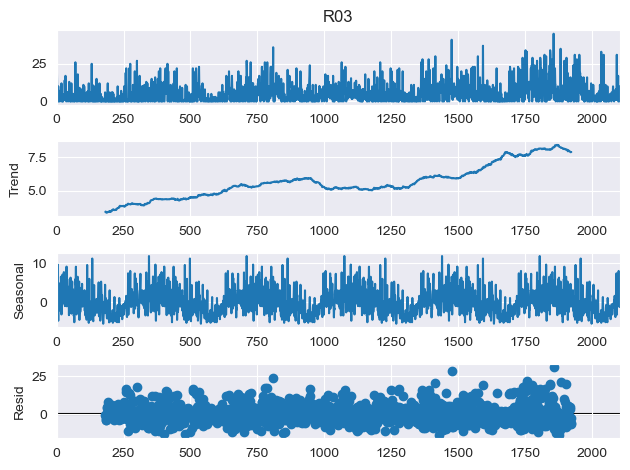

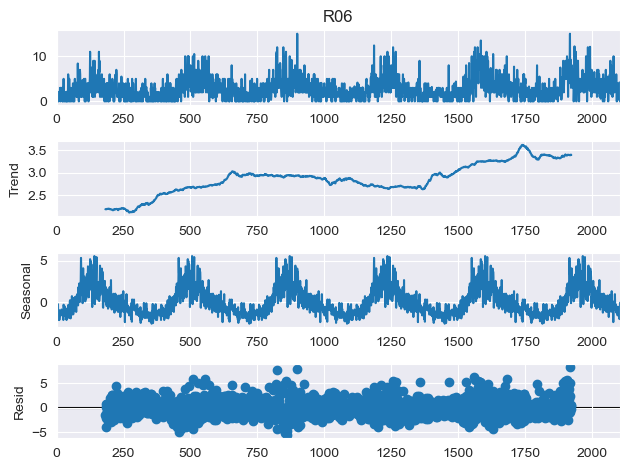

In [54]:
#Декомпозиция временных рядов категорий лекарств
print('\033[1m' + 'ДЕКОМПОЗИЦИЯ ВРЕМЕННЫХ РЯДОВ РАЗНЫХ КАТЕГОРИЙ ЛЕКАРСТВ:' + '\033[0m')
for _, view in enumerate(col):
    result = seasonal_decompose(dynam[view], model='additive', period=365)
    result.plot()
    plt.show()

**При декомпозиции временных рядов разных категорий лекарств можно прийти к выводу о том, что при из разбитии на тренд-сезонная модель хорошо объясняет их поведение. Колебания остатков происходят в довольно ограниченной амплитуде практически во всех категориях, кроме "NO2BE", что говорит о том, что поведение рассматриваемых временных рядов не совсем хаотично и может быть объяснено характером их компонент.**

"ЯЩИКИ С УСАМИ" ПРОДАЖ РАЗНЫХ КАТЕГОРИЙ ЛЕКАРСТВ:


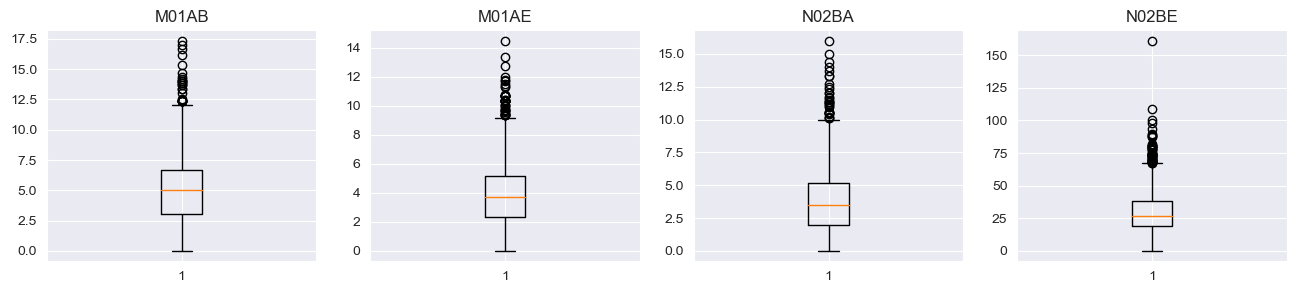

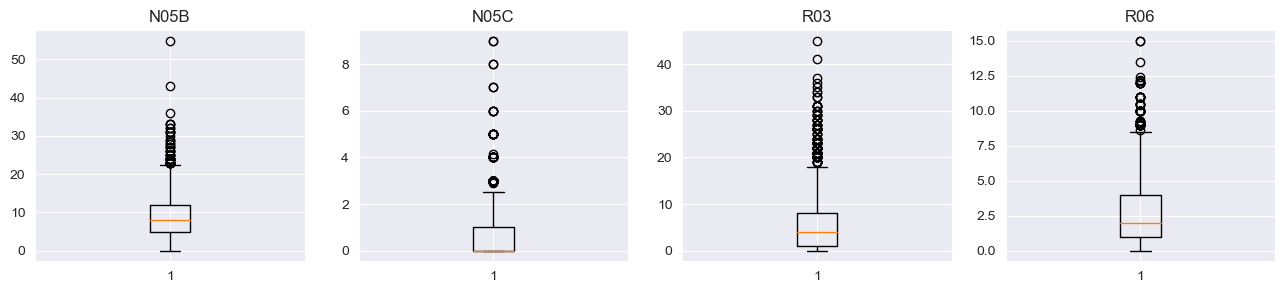

In [55]:
#Построение "ящиков с усами" для выявлении выбросов в данных
print('\033[1m' + '"ЯЩИКИ С УСАМИ" ПРОДАЖ РАЗНЫХ КАТЕГОРИЙ ЛЕКАРСТВ:' + '\033[0m')
for _, view in enumerate(col):
    if (_)%4+2 == 2:
        plt.figure(figsize=(16,3))
    plt.subplot(1, 4, (_)%4+1)
    plt.boxplot(dynam[view])
    plt.title(view)
    if (_)%4+2 == 0: 
        plt.show()

**При условии нескольких тысяч точек значений выбросы единичны. Наиболее существенный выброс наблюдается в ранее уже упомянутом "проблемной" категории "N02BE. Тем не менее, датасет сформирвоан из реальныз данных, поэтому никакие записи удалять нельзя. Можно считать, что иногда, по каким-то причинам, бывают аномальные изменения величины спроса на разные категории лекарств, и будущая прогнозная модель должна достойно работать в рамках этого допущения.**

РАСПЕРЕДЕЛЕНИЕ ФАКТОВ РАЗНЫХ КАТЕГОРИЙ ЛЕКАРСТВ:


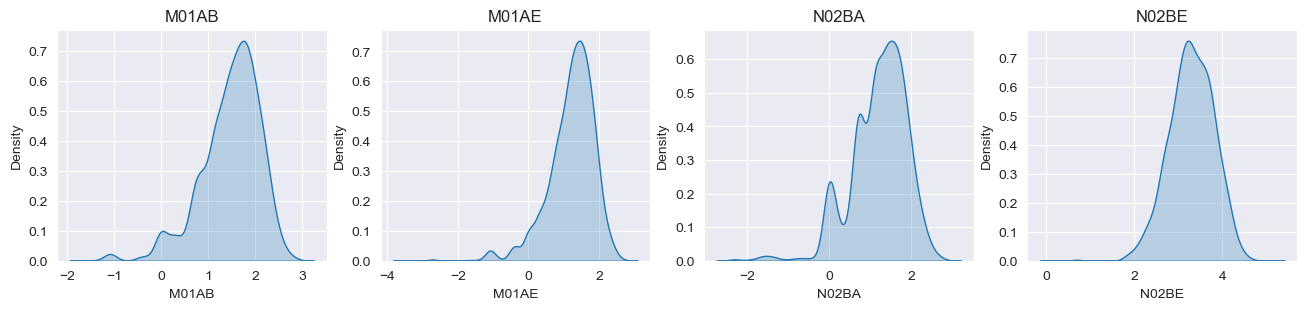

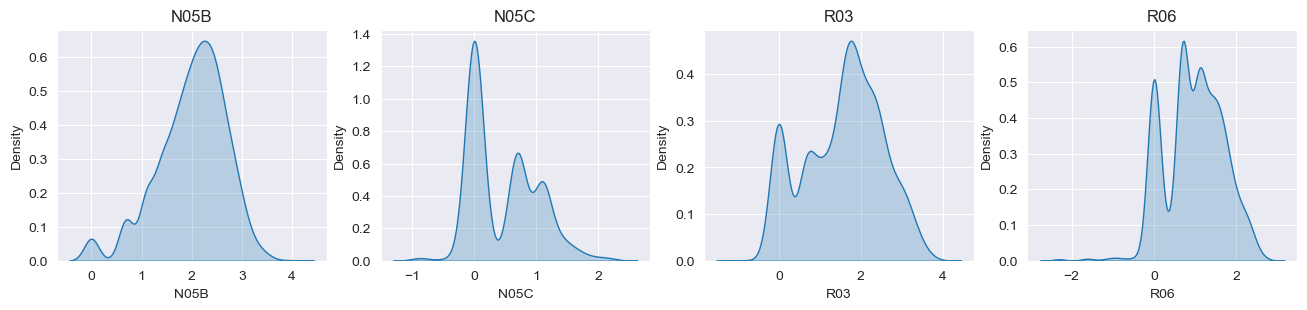

In [56]:
#Построение гистограмм распределений
print('\033[1m' + 'РАСПЕРЕДЕЛЕНИЕ ФАКТОВ РАЗНЫХ КАТЕГОРИЙ ЛЕКАРСТВ:' + '\033[0m')
for _, view in enumerate(col):
    if (_)%4+2 == 2:
        plt.figure(figsize=(16,3))
    plt.subplot(1, 4, (_)%4+1)
    sns.kdeplot(np.log(dynam[view]), shade=True)
    plt.title(view)
    if (_)%4+2 == 0: 
        plt.show()

**Как можно заметить: все факты категорий лекарств, кроме "N05C", "К03" и "R06", имеют распределение, близкое к нормальному, поэтому работа прогнозных моделей с ними будет упрощена. В категориях "N05C", "К03" и "R06" имеет место быть двупиковость с ассиметрией, которая, скорее всего, была вызвана наличием несколько "аномальных" значений в некоторые дни продаж. Тем не менее, ввиду реальности данных прогнозирование будет проводиться на неизменённом датасете.**

In [57]:
#Формирование параметров нейронной сети:
class LSTM_():
    def init(self, params, input_shape):
            model = Sequential()
            model.add(LSTM(units=params["lstm_units"], return_sequences=True, input_shape=(input_shape, 1)))
            model.add(Dropout(rate=params["dropout"]))

            model.add(LSTM(units=params["lstm_units"], return_sequences=True))
            model.add(Dropout(rate=params["dropout"]))

            model.add(LSTM(units=params["lstm_units"], return_sequences=True))
            model.add(Dropout(rate=params["dropout"]))

            model.add(LSTM(units=params["lstm_units"], return_sequences=False))
            model.add(Dropout(rate=params["dropout"]))

            model.add(Dense(1))

            model.compile(loss=params["loss"],
                        optimizer=params["optimizer"],
                        metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
            return model
LSTM_ = LSTM_()

def optimization(x):
    dynamics_previous1[view] = x[0]*dynamics_prepast[view] + x[1]*dynamics_preprevious[view]
    coef = sum(abs(dynamics_previous1[view] - dynamics_previous[view]))
    return(coef)

params = {
        "loss": "mean_squared_error",
        "optimizer": "adam",
        "dropout": 0.1,
        "lstm_units": 120,
        "epochs": 5,
        "batch_size": 2,
        "es_patience": 10
         }

In [58]:
#Создание датафреймов накопления результатов
errors_cul = pd.DataFrame()
long_cul = pd.DataFrame()
short_cul = pd.DataFrame()
tools_cul = pd.DataFrame()
count = 0 

for view in col: #перебор всех категорий лекарств
    count += 1
    #Выделение связанных с целевым месяцем месяцев для расчёта дневной детализации:
    dynamics = dynam[['datum', view]].copy()
    dynamics_target = dynamics[(dynamics['datum'] >= start) & (dynamics['datum'] <= end)]  
    dynamics_past = dynamics[(dynamics['datum'] >= (start - pd.DateOffset(years=year_diff))) & (dynamics['datum'] <= (end - pd.DateOffset(years=year_diff)))] 
    dynamics_previous = dynamics[(dynamics['datum'] >= (start - pd.DateOffset(months=1))) & (dynamics['datum'] <= (end - pd.DateOffset(months=1)))] 
    dynamics_prepast = dynamics[(dynamics['datum'] >= (start - pd.DateOffset(years=year_diff) - pd.DateOffset(months=1))) & (dynamics['datum'] <= (end - pd.DateOffset(years=year_diff) - pd.DateOffset(months=1)))] 
    dynamics_preprevious = dynamics[(dynamics['datum'] >= (start - pd.DateOffset(months=2))) & (dynamics['datum'] <= (end - pd.DateOffset(months=2)))]
    
    #Уравнение дней в месяцах для дневной детализации:
    if  dynamics_past.shape[0] == 30:
        dynamics_previous = dynamics_previous.iloc[0:30,]
        dynamics_prepast = dynamics_prepast.iloc[0:30,]
        dynamics_preprevious = dynamics_preprevious.iloc[0:30,]
    elif dynamics_past.shape[0] == 31:
        if dynamics_previous.shape[0] != 31: 
            dynamics_previous = dynamics_previous.append(dynamics_previous.iloc[29:30,0:2])
        if dynamics_preprevious.shape[0] != 31:
            dynamics_preprevious = dynamics_preprevious.append(dynamics_preprevious.iloc[29:30,0:2])
        if dynamics_prepast.shape[0] != 31: 
            dynamics_prepast = dynamics_prepast.append(dynamics_prepast.iloc[29:30,0:2])
    elif dynamics_previous.month == 1 and dynamics_previous.year % 4 == 0 and dynamics_previous.year % 100 != 0 or dynamics_previous.year % 400 == 0:
        dynamics_previous = dynamics_previous.iloc[0:29,0:2]
        dynamics_prepast = dynamics_prepast.iloc[0:29,0:2]
        dynamics_preprevious = dynamics_preprevious.iloc[0:29,0:2]
    else:
        dynamics_previous = dynamics_previous.iloc[0:28,0:2]
        dynamics_prepast = dynamics_prepast.iloc[0:28,0:2]
        dynamics_preprevious = dynamics_preprevious.iloc[0:28,0:2]
        
    #Сброс индексов в вырезанных месяцах
    dynamics_target = dynamics_target.reset_index(drop=True)
    dynamics_past = dynamics_past.reset_index(drop=True)
    dynamics_previous = dynamics_previous.reset_index(drop=True)
    dynamics_prepast = dynamics_prepast.reset_index(drop=True)
    dynamics_preprevious = dynamics_preprevious.reset_index(drop=True)
    
    #Расчёт оптимальных коэффициентов комбинирования
    dynamics_previous1 = pd.DataFrame()
    res = minimize(optimization, [2,2], method='SLSQP')

    #Расчёт ежедневных коэффициентов для дневной детализации целевого месяца
    short_forecast = dynamics_past
    short_forecast['datum'] += pd.DateOffset(years=year_diff)
    short_forecast[view] = res['x'][0]*dynamics_past[view] + res['x'][1]*dynamics_previous[view]
    short_forecast[view] = short_forecast[view]/sum(short_forecast[view])
    
    #Разбиение датасета на обучающую и тестовую выборки
    difference = (dynamics_previous.iloc[0,0].year - dynamics.iloc[0,0].year) * 12 + dynamics_previous.iloc[0,0].month
    cut = difference*0.2 - 1
    cut = round(cut, 0)
    cut = dynamics_previous.iloc[0,0] - pd.DateOffset(months=cut)
    dynamics_train = dynamics[(dynamics['datum'] >= dynamics.iloc[0,0]) & (dynamics['datum'] < cut)]
    dynamics_test = dynamics[(dynamics['datum'] >= cut) & (dynamics['datum']<=(end-pd.DateOffset(months=1)))]
    dynamics_full = dynamics.groupby(dynamics['datum'].dt.strftime('%Y-%m'))[view].sum()
    dynamics_train = dynamics_train.groupby(dynamics_train['datum'].dt.strftime('%Y-%m'))[view].sum()
    dynamics_test = dynamics_test.groupby(dynamics_test['datum'].dt.strftime('%Y-%m'))[view].sum()
    
    #Построение прогнозных моделей на выборках
    warnings.filterwarnings("ignore")

    hw1 = ExponentialSmoothing(dynamics_train, seasonal = 'add',seasonal_periods=12).fit() #Метод Хольта-Уинтерса
    hw1 = hw1.predict(start=cut, end=(start-pd.DateOffset(months=1)))
    hw2 = ExponentialSmoothing(dynamics_train, seasonal = 'mul',seasonal_periods=12).fit()
    hw2 = hw2.predict(start=cut, end=(start-pd.DateOffset(months=1))) #ETS-модель
    if mse(dynamics_test, hw1) < mse(dynamics_test, hw2): #Побор типа сезонности
        hw_seas = 'add'  
    else:
        hw_seas = 'mul'

    ets1 = ETSModel(dynamics_train, seasonal = 'add',seasonal_periods=12).fit() #ETS-модель
    ets1 = ets1.predict(start=cut, end=(start-pd.DateOffset(months=1)))
    ets2 = ETSModel(dynamics_train, seasonal = 'mul',seasonal_periods=12).fit()
    ets2 = ets2.predict(start=cut, end=(start-pd.DateOffset(months=1)))
    if mse(dynamics_test, ets1) < mse(dynamics_test, ets2): #Побор типа сезонности
        ets_seas = 'add'  
    else:
        ets_seas = 'mul'

    hw_test_model = ExponentialSmoothing(dynamics_train, seasonal = hw_seas, seasonal_periods=12).fit() #Метод Хольта-Уинтерса
    hw_test = hw_test_model.predict(start=cut, end=(start-pd.DateOffset(months=1))) 

    ETS_test_model = ETSModel(dynamics_train, seasonal = ets_seas, seasonal_periods=12).fit() #ETS-модель
    ETS_test = ETS_test_model.predict(start=cut, end=(start-pd.DateOffset(months=1)))

    sarima_test_model = SARIMAX(dynamics_train, freq='MS', enforce_stationarity=False, enforce_invertibility=False).fit() #SARIMA
    sarima_test = sarima_test_model.predict(start=cut, end=(start-pd.DateOffset(months=1)))
    
    dynam_train = pd.DataFrame(dynamics_train).reset_index().copy() #LSTM-нейронная сеть
    dynam_train['datum'] = pd.to_datetime(dynam_train['datum'], errors='coerce')
    dynam_train['month'] = dynam_train['datum'].dt.month
    dynam_train['year'] = dynam_train['datum'].dt.year
    xtrain = dynam_train[['year', 'month']]
    ytrain = dynam_train[[view]]
    
    dynam_test = pd.DataFrame(dynamics_test).reset_index().copy()
    dynam_test['datum'] = pd.to_datetime(dynam_test['datum'], errors='coerce')
    dynam_test['month'] = dynam_test['datum'].dt.month
    dynam_test['year'] = dynam_test['datum'].dt.year
    xtest = dynam_test[['year', 'month']]
    ytest = dynam_test[[view]]

    LSTM_model = LSTM_.init(params=params, input_shape=xtrain.shape[1])

    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                               mode='min', patience=params["es_patience"])

    LSTM_model.fit(
        xtrain,
        ytrain,
        validation_data=(xtest, ytest),
        epochs=params["epochs"],
        batch_size=params["batch_size"],
        verbose=0,
        )

    LSTM_test = LSTM_model.predict(xtest)
    LSTM_test = pd.concat([pd.DataFrame(sarima_test.reset_index()), pd.DataFrame(LSTM_test)], axis = 1)[['index', 0]]
    LSTM_test['index'] = pd.to_datetime(LSTM_test['index'], errors='coerce')
    LSTM_test = LSTM_test.groupby(LSTM_test['index'].dt.strftime('%Y-%m')).sum()

    #Расчёт ошибок прогноза моделей прогнозирования на тестовом периоде
    MAE = 'MAE (' + view + ')'
    RMSE = 'RMSE (' + view + ')'
    MAPE = 'MAPE,% (' + view + ')'

    errors = pd.DataFrame(columns=['Метод', MAE, RMSE, MAPE])
    hw_row = {'Метод':'Хольт-Унитерс', MAE: round(mae(dynamics_test, hw_test), 2), RMSE: round(mse(dynamics_test, hw_test)**0.5, 2), MAPE:round(mape(dynamics_test, hw_test), 4)*100}
    ETS_row = {'Метод':'ETS', MAE: round(mae(dynamics_test, ETS_test), 2), RMSE: round(mse(dynamics_test, ETS_test)**0.5, 2), MAPE:round(mape(dynamics_test, ETS_test), 4)*100}
    sarima_row = {'Метод':'SARIMA', MAE: round(mae(dynamics_test, sarima_test), 2), RMSE: round(mse(dynamics_test, sarima_test)**0.5, 2), MAPE:round(mape(dynamics_test, sarima_test), 4)*100}
    LSTM_row = {'Метод':'LSTM', MAE: round(mae(dynamics_test, LSTM_test), 2), RMSE: round(mse(dynamics_test, LSTM_test)**0.5, 2), MAPE:round(mape(dynamics_test, LSTM_test), 4)*100}
    errors = errors.append(hw_row, ignore_index=True)
    errors = errors.append(ETS_row, ignore_index=True)
    errors = errors.append(sarima_row, ignore_index=True)
    errors = errors.append(LSTM_row, ignore_index=True)

    #Расчёт ошибок прогноза для комбинации моделей прогнозирования
    exclude = max(errors[RMSE])
    for i in range(0,errors.shape[0]):
        if  errors.iloc[i,errors.columns.get_loc(RMSE)] == exclude:
            ex = i
            break
    fit_methods = errors.drop([errors.index[ex]])
    fit_methods = fit_methods.reset_index(drop=True)
    errors_f = errors.drop([errors.index[ex]])

    exclude = max(errors_f[RMSE])
    for i in range(0,errors_f.shape[0]):
        if  errors_f.iloc[i,errors_f.columns.get_loc(RMSE)] == exclude:
            ex = i
            break
    fit_methods = errors_f.drop([errors_f.index[ex]]).reset_index(drop=True)

    first_coef = 1 - fit_methods.iloc[0,fit_methods.columns.get_loc(RMSE)]/sum(fit_methods[RMSE])
    second_coef = 1 - fit_methods.iloc[1,fit_methods.columns.get_loc(RMSE)]/sum(fit_methods[RMSE])
    sum_coef = first_coef + second_coef
    first_coef = first_coef / sum_coef
    second_coef = second_coef / sum_coef

    if [fit_methods.iloc[0,fit_methods.columns.get_loc("Метод")], fit_methods.iloc[1,fit_methods.columns.get_loc("Метод")]]  == ['Хольт-Унитерс', 'ETS']:
        combination_test = first_coef*hw_test + second_coef*ETS_test
        row1, row2 = 0,1
    elif [fit_methods.iloc[0,fit_methods.columns.get_loc("Метод")], fit_methods.iloc[1,fit_methods.columns.get_loc("Метод")]]  == ['ETS', 'SARIMA']:
        combination_test = first_coef*ETS_test + second_coef*sarima_test
        row1, row2 = 1,2
    elif [fit_methods.iloc[0,fit_methods.columns.get_loc("Метод")], fit_methods.iloc[1,fit_methods.columns.get_loc("Метод")]]  == ['Хольт-Унитерс', 'SARIMA']:
        combination_test = first_coef*hw_test + second_coef*sarima_test
        row1, row2 = 0,2
    elif [fit_methods.iloc[0,fit_methods.columns.get_loc("Метод")], fit_methods.iloc[1,fit_methods.columns.get_loc("Метод")]]  == ['Хольт-Унитерс', 'LSTM']:
        combination_test = first_coef*pd.DataFrame(hw_test).reset_index()[0] + second_coef*LSTM_test.reset_index()[0]
        row1, row2 = 0,3
    elif [fit_methods.iloc[0,fit_methods.columns.get_loc("Метод")], fit_methods.iloc[1,fit_methods.columns.get_loc("Метод")]]  == ['ETS', 'LSTM']:
        combination_test = first_coef*pd.DataFrame(ETS_test).reset_index()[0] + second_coef*LSTM_test.reset_index()[0]
        combination_test = first_coef*pd.DataFrame(ETS_test).reset_index()[0] + second_coef*LSTM_test.reset_index()[0]
        row1, row2 = 1,3
    elif [fit_methods.iloc[0,fit_methods.columns.get_loc("Метод")], fit_methods.iloc[1,fit_methods.columns.get_loc("Метод")]]  == ['SARIMA', 'LSTM']:
        combination_test = first_coef*pd.DataFrame(sarima_test).reset_index()['predicted_mean'] + second_coef*LSTM_test.reset_index()[0]
        row1, row2 = 2,3


    errors_comb = pd.DataFrame(columns=['Метод', MAE, RMSE, MAPE])
    comb_row = {'Метод':'Комбинация 2-х лучших методов', MAE: round(mae(dynamics_test, combination_test), 2), RMSE: round(mse(dynamics_test, combination_test)**0.5, 2), MAPE:round(mape(dynamics_test, combination_test), 4)*100}
    errors_comb = errors_comb.append(comb_row, ignore_index=True)

    #Построение долгосрочного прогноза
    hw_model = ExponentialSmoothing(dynamics_full, seasonal = hw_seas,seasonal_periods=12).fit()
    hw = hw_model.predict(start=daily, end=monthly) #Метод Хольта-Уинтерса

    ETS_model = ETSModel(dynamics_full, seasonal = ets_seas, seasonal_periods=12).fit()
    ETS = ETS_model.predict(start=daily, end=monthly) #ETS-модель

    sarima_model = SARIMAX(dynamics_full, freq='MS', enforce_stationarity=False, enforce_invertibility=False).fit()
    sarima = sarima_model.predict(start=daily, end=monthly) #SARIMA-модель

    dynamics_full = dynamics_full.reset_index()
    dynamics_full['datum'] = pd.to_datetime(dynamics_full['datum'], errors='coerce')
    dynamics_full = dynamics_full[dynamics_full['datum'] < end].iloc[:-1,:]
    dynamics_full['month'] = dynamics_full['datum'].dt.month
    dynamics_full['year'] = dynamics_full['datum'].dt.year
    xtrain_full = dynamics_full[['year', 'month']]
    ytrain_full = dynamics_full[view]

    LSTM_model.fit(
        xtrain_full,
        ytrain_full,
        epochs=params["epochs"],
        batch_size=params["batch_size"],
        verbose=0,
                  )
    future_dates = pd.DataFrame(sarima).reset_index().copy()
    future_dates['index'] = pd.to_datetime(future_dates['index'], errors='coerce')
    future_dates['year'] = future_dates['index'].dt.year
    future_dates['month'] = future_dates['index'].dt.month
    x_full = future_dates[['year', 'month']]


    LSTM_for = LSTM_model.predict(x_full) #LSTM-модель

    LSTM_for = pd.concat([pd.DataFrame(sarima.reset_index()), pd.DataFrame(LSTM_for)], axis = 1)[['index', 0]]
    LSTM_for['index'] = pd.to_datetime(LSTM_for['index'], errors='coerce')
    LSTM_for = LSTM_for.groupby(LSTM_for['index'].dt.strftime('%Y-%m')).sum()

    tools = pd.DataFrame()
    tools = []

    z = 0
    n = 0
    if errors_comb[MAPE].iloc[0] < np.min(errors[MAPE]):
        if (row1 == 0) & (row2 == 1):
            long_forecast = first_coef*hw + second_coef*ETS
            tools.append([view, 'Комбинация Хольта-Уинтерса и ETS-модели'])
        elif (row1 == 1) & (row2 == 2):
            long_forecast = first_coef*ETS + second_coef*sarima
            tools.append([view, 'Комбинация ETS-модели и SARIMA'])
        elif (row1 == 0) & (row2 == 2):
            long_forecast = first_coef*hw + second_coef*sarima
            tools.append([view, 'Комбинация Хольта-Уинтерса и SARIMA'])
        elif (row1 == 0) & (row2 == 3):
            long_forecast = first_coef*hw.reset_index()[0] + second_coef*LSTM_for.reset_index()[0]
            tools.append([view, 'Комбинация Хольта-Уинтерса и LSTM'])
            n=+1
        elif (row1 == 1) & (row2 == 3):
            long_forecast = first_coef*ETS.reset_index()[0] + second_coef*LSTM_for.reset_index()[0]
            tools.append([view, 'Комбинация ETS-модели и LSTM'])
            n=+1
        elif (row1 == 2) & (row2 == 3):
            long_forecast = first_coef*sarima.reset_index()['predicted_mean'] + second_coef*LSTM_for.reset_index()[0]
            tools.append([view, 'Комбинация SARIMA и LSTM'])
            n=+1
    else:
        include = min(errors[MAPE])
        for i in range(errors.shape[0]):
            if  errors.iloc[i, errors.columns.get_loc(MAPE)] == include:
                inc = i
                break
        if inc == 0:
            long_forecast = hw
            tools.append([view, 'Хольт-Уинтерс'])

        elif inc == 1:
            long_forecast = ETS
            tools.append([view, 'ETS-модель'])
        elif inc == 2:
            long_forecast = sarima
            tools.append([view, 'SARIMA'])
        else:
            long_forecast = LSTM_for
            tools.append([view, 'LSTM'])
            z += 1

    #Формирование таблиц с краткосрочным и долгосрочным прогнозом
    if z == 0 & n == 0:
        short_forecast[view] = short_forecast[view] * long_forecast.iloc[0]
        short_forecast[view] = round(short_forecast[view], 2)
        short_forecast['datum'] = short_forecast['datum'].dt.date
        short_forecast[view] = round(short_forecast[view], 2)
        short_forecast.columns = ['Дата', view]

        long_forecast = pd.DataFrame(long_forecast)
        long_forecast.index = pd.to_datetime(long_forecast.index)
        long_forecast ['Дата'] = long_forecast.index
        long_forecast [view] = long_forecast.iloc[:,0]
        long_forecast = long_forecast.iloc[:,1:]
        long_forecast = long_forecast.reset_index(drop=True)
        long_forecast['Дата'] = long_forecast['Дата'].dt.strftime('%Y-%m')
        long_forecast[view] = round(long_forecast[view], 2)
    elif z == 1:
        short_forecast[view] = short_forecast[view] * LSTM_for.reset_index()[0].iloc[0]
        short_forecast[view] = round(short_forecast[view], 2)
        short_forecast['datum'] = short_forecast['datum'].dt.date
        short_forecast[view] = round(short_forecast[view], 2)
        short_forecast.columns = ['Дата', view]

        long_forecast = pd.DataFrame(LSTM_for).reset_index()
        long_forecast ['Дата'] = long_forecast['index']
        long_forecast [view] = long_forecast[0]
        long_forecast = long_forecast[['Дата', view]]
        long_forecast['Дата'] = pd.to_datetime(long_forecast['Дата']).dt.strftime('%Y-%m')
        long_forecast[view] = round(long_forecast[view], 2)
    else:
        short_forecast[view] = short_forecast[view] * long_forecast.iloc[0]
        short_forecast[view] = round(short_forecast[view], 2)
        short_forecast['datum'] = short_forecast['datum'].dt.date
        short_forecast[view] = round(short_forecast[view], 2)
        short_forecast.columns = ['Дата', view]

        long_forecast = pd.DataFrame(long_forecast)
        long_forecast['Дата'] = future_dates['index']
        long_forecast[view] = long_forecast[0]
        long_forecast = long_forecast[['Дата', view]]
        long_forecast['Дата'] = pd.to_datetime(long_forecast['Дата']).dt.strftime('%Y-%m')
        long_forecast[view] = round(long_forecast[view], 2)

    #Формирование таблиц с результатами
    if count == 1:
        errors_cul = pd.concat([errors_cul, errors.append(errors_comb, ignore_index = True)], axis = 1)
        long_cul = pd.concat([long_cul, long_forecast], axis = 1)
        short_cul = pd.concat([short_cul, short_forecast], axis = 1)
    else:
        errors_cul = pd.concat([errors_cul, errors.iloc[:,1:].append(errors_comb.iloc[:,1:], ignore_index = True)], axis = 1)
        long_cul = pd.concat([long_cul, long_forecast.iloc[:,1]], axis = 1)
        short_cul = pd.concat([short_cul, short_forecast.iloc[:,1]], axis = 1)
    tools_cul = tools_cul.append(tools)

1/1 [==============================] - 0s 26ms/step


In [59]:
#Вывод таблицы со статистическими ошибками
pd.set_option('display.max_columns', None)
print('\033[1m' + 'СТАТИСТИЧЕСКИЕ ОШИБКИ НА ТЕСТОВЫХ ПЕРИОДАХ:' + '\033[0m')
errors_cul

СТАТИСТИЧЕСКИЕ ОШИБКИ НА ТЕСТОВЫХ ПЕРИОДАХ:


,Метод,MAE (M01AB),RMSE (M01AB),"MAPE,% (M01AB)",MAE (M01AE),RMSE (M01AE),"MAPE,% (M01AE)",MAE (N02BA),RMSE (N02BA),"MAPE,% (N02BA)",MAE (N02BE),RMSE (N02BE),"MAPE,% (N02BE)",MAE (N05B),RMSE (N05B),"MAPE,% (N05B)",MAE (N05C),RMSE (N05C),"MAPE,% (N05C)",MAE (R03),RMSE (R03),"MAPE,% (R03)",MAE (R06),RMSE (R06),"MAPE,% (R06)"
0,Хольт-Унитерс,13.78,16.46,8.92,13.87,21.58,10.17,9.25,12.27,10.38,117.35,167.88,11.76,43.57,48.05,16.84,5.87,6.72,28.26,70.21,89.72,26.28,18.72,26.02,18.59
1,ETS,13.77,16.45,8.91,13.87,21.58,10.17,9.25,12.27,10.38,119.75,168.33,12.29,43.61,48.12,16.86,5.87,6.72,28.26,70.16,89.73,26.22,18.72,26.01,18.58
2,SARIMA,21.78,26.90,13.12,14.77,26.17,10.10,19.94,24.08,20.38,477.95,555.65,48.18,72.49,80.08,26.77,14.10,15.69,63.97,170.93,193.82,65.98,45.24,57.08,45.41
3,LSTM,127.59,128.38,81.22,91.40,94.49,75.53,64.07,64.80,68.70,892.92,939.51,96.48,235.07,236.75,88.51,5.26,5.83,25.52,208.70,227.52,85.32,74.78,87.02,65.52
4,Комбинация 2-х лучших методов,13.77,16.46,8.92,13.87,21.58,10.17,9.25,12.27,10.38,118.44,167.92,12.01,43.59,48.09,16.85,5.40,6.02,26.14,70.18,89.72,26.25,18.72,26.01,18.58


In [60]:
#Вывод таблицы c выбранными моделями прогнозирования для разных категорий:
print('\033[1m' + 'ОПТИМАЛЬНЫЕ МОДЕЛИ ПРОГНОЗИРОВАНИЯ ДЛЯ КАЖДОЙ КАТЕГОРИИ:' + '\033[0m')
tools_cul.columns = ['Категория', 'Оптимальная модель']
tools_cul = tools_cul.reset_index(drop = True)
tools_cul

ОПТИМАЛЬНЫЕ МОДЕЛИ ПРОГНОЗИРОВАНИЯ ДЛЯ КАЖДОЙ КАТЕГОРИИ:


,Категория,Оптимальная модель
0,M01AB,ETS-модель
1,M01AE,SARIMA
2,N02BA,Хольт-Уинтерс
3,N02BE,Хольт-Уинтерс
4,N05B,Хольт-Уинтерс
5,N05C,LSTM
6,R03,ETS-модель
7,R06,ETS-модель


ВИЗУАЛИЗАЦИЯ ПРОГНОЗОВ ОПТИМАЛЬНЫХ МОДЕЛЕЙ ДЛЯ КАЖДОЙ КАТЕГОРИИ:


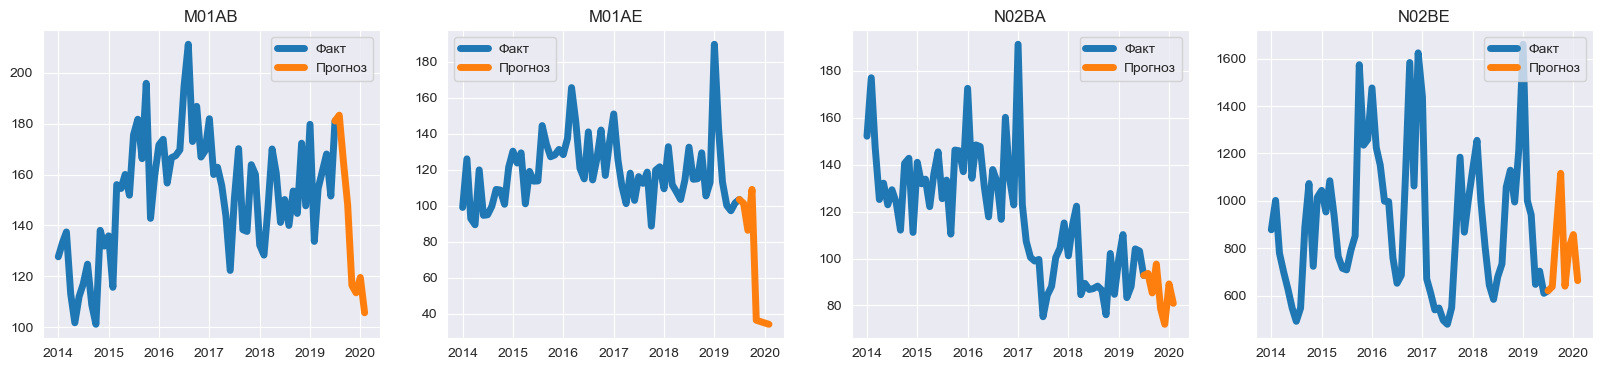

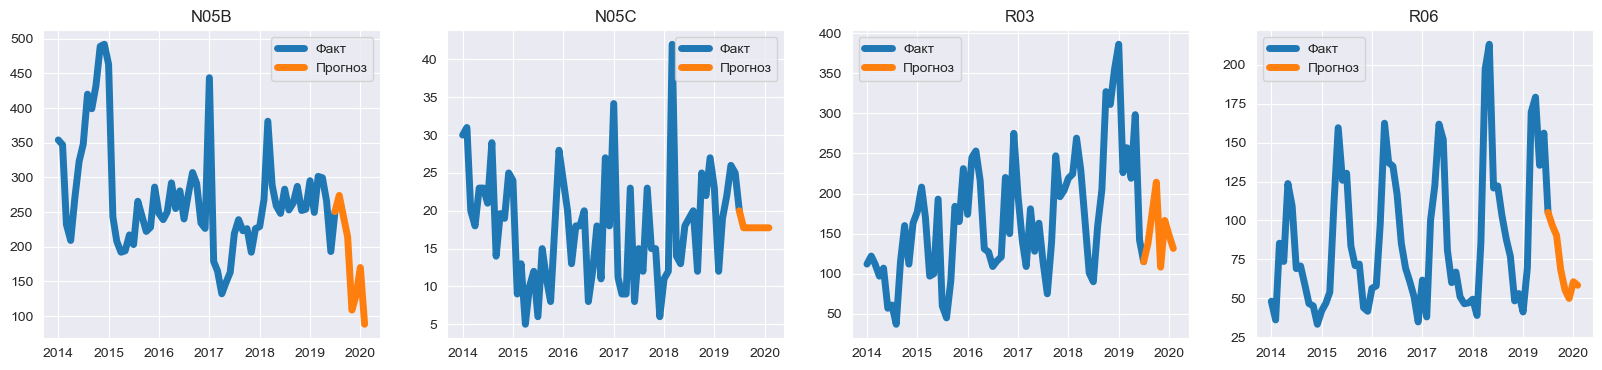

In [61]:
#Визуализация прогнозов:
print('\033[1m' + 'ВИЗУАЛИЗАЦИЯ ПРОГНОЗОВ ОПТИМАЛЬНЫХ МОДЕЛЕЙ ДЛЯ КАЖДОЙ КАТЕГОРИИ:' + '\033[0m')
dynam_full = dynam.groupby(dynam['datum'].dt.strftime('%Y-%m')).sum().reset_index()
dynam_full['datum'] = pd.to_datetime(dynam_full['datum'], errors='coerce')
dynam_full = dynam_full[dynam_full['datum'] < daily]

col.insert(0, 'datum')

long_cul.rename(columns={'Дата': 'datum'}, inplace=True)
long_cul['datum'] = pd.to_datetime(long_cul['datum'], errors='coerce')

long_cul_full = long_cul.append(dynam_full.iloc[dynam_full.shape[0] - 1:dynam_full.shape[0], :][col]).sort_values(by='datum')

col.pop(0)

for _,view in enumerate(col):
    if (_)%4+2 == 2:
        plt.figure(figsize=(20, 4))
    plt.subplot(1, 4, (_)%4+1)
    plt.plot(dynam_full['datum'], dynam_full[view], label = 'Факт', linewidth = 5)
    plt.plot(pd.to_datetime(long_cul_full['datum'], errors='coerce'), long_cul_full[view], label = 'Прогноз', linewidth = 5)
    plt.legend()
    plt.title(view)
    if (_)%4+2 == 0: 
        plt.show()

In [62]:
#Вывод таблицы с прогнозным планом:
pd.set_option('display.max_rows', None)
long_cul.rename(columns={'datum': 'Дата'}, inplace=True)

print('\033[1m' + 'ПРОГНОЗНЫЙ ПЛАН:' + '\033[0m')
long_cul[col] = long_cul[col].astype('float64').round(2)
long_cul['Дата'] = long_cul['Дата'].dt.strftime('%Y-%m')
long_cul

ПРОГНОЗНЫЙ ПЛАН:


,Дата,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,2019-08,183.29,101.37,93.67,638.17,273.98,17.75,137.58,96.88
1,2019-09,164.70,86.42,85.35,892.52,243.14,17.75,176.62,90.40
2,2019-10,148.16,109.10,97.63,1115.98,214.04,17.75,214.10,68.48
3,2019-11,116.45,36.52,78.60,640.08,108.56,17.75,108.21,55.50
4,2019-12,113.56,35.75,71.99,804.13,129.88,17.75,166.39,49.97
5,2020-01,119.58,35.00,89.17,857.76,169.95,17.75,148.30,60.69
6,2020-02,105.71,34.26,80.91,663.49,88.07,17.75,131.49,58.43


In [63]:
#Вывод таблицы с детализацией первого месяца прогнозного плана:
pd.set_option('display.max_rows', None)
print('\033[1m' + 'ДЕТАЛИЗАЦИЯ ПЕРВОГО МЕСЯЦА ПРОГНОЗНОГО ПЛАНА:' + '\033[0m')
short_cul

ДЕТАЛИЗАЦИЯ ПЕРВОГО МЕСЯЦА ПРОГНОЗНОГО ПЛАНА:


,Дата,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,2019-08-01,2.87,2.01,1.04,13.18,8.82,1.00,7.82,5.56
1,2019-08-02,2.19,2.00,1.70,11.75,11.00,0.00,1.30,4.44
2,2019-08-03,4.79,2.59,2.93,23.99,9.79,0.00,0.96,1.90
3,2019-08-04,6.11,2.46,1.23,9.86,10.04,2.89,2.87,6.98
4,2019-08-05,6.53,2.03,4.77,15.50,7.72,2.00,1.04,1.44
5,2019-08-06,8.42,3.40,2.50,17.63,5.20,0.00,2.00,2.19
6,2019-08-07,4.07,4.50,6.19,18.78,5.20,1.00,3.04,3.45
7,2019-08-08,5.82,3.45,2.08,14.72,12.31,-0.11,3.82,2.51
8,2019-08-09,3.19,2.68,4.02,20.97,13.66,-0.46,2.87,1.87
9,2019-08-10,8.72,4.62,4.58,18.17,7.34,0.00,0.96,2.51


In [64]:
end_time = datetime.now()
print('\033[1m' + 'ВРЕМЯ ВЫПОЛНЕНИЯ ИТ-РЕШЕНИЯ:' + '\033[0m')
print(str('Duration: {}'.format(end_time - start_time))[:16])

ВРЕМЯ ВЫПОЛНЕНИЯ ИТ-РЕШЕНИЯ:
Duration: 0:05:4
